**Mount Google Drive**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


**Change Directory to Working Directory**

In [0]:
import os
os.chdir('/content/gdrive/My Drive/132A/Project')
!ls

 16QAM		     LLRs_4QAM_10.png   loss_16QAM_15.png   loss_BPSK_20.png
 4QAM		     LLRs_4QAM_15.png   loss_4QAM_10.png    Mixed
 BPSK		     LLRs_4QAM_20.png   loss_4QAM_15.png    Parameters.gsheet
'BPSK Trash Data'    LLRs_BPSK_10.png   loss_4QAM_20.png    Plots
 LLRs_16QAM_10.png   LLRs_BPSK_15.png   loss_BPSK_10.png
 LLRs_16QAM_15.png   LLRs_BPSK_20.png   loss_BPSK_15.png


**Load and Preprocess MATLAB Data**

In [0]:
import numpy as np
import pandas as pd
import scipy.io as sio

def unison_shuffled_copies(a, b, c, d):
    assert (len(a) == len(b)) and (len(a) == len(c)) and (len(b) == len(c)) and (len(a)==len(d))
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p], d[p]

sym_r = []
sym_i = []
LLR0 = []
LLR1 = []
for i in range(4):
  x = sio.loadmat('4QAM/Raw Data/15 dB/4QAM_sym_15_' + str(i+1) + '.mat')
  y0 = sio.loadmat('4QAM/Raw Data/15 dB/4QAM_LLR_b0_15_' + str(i+1) + '.mat')
  y1 = sio.loadmat('4QAM/Raw Data/15 dB/4QAM_LLR_b1_15_' + str(i+1) + '.mat')
  x_d = x['z_4QAM']
  LLR_b0 = y0['LLR_BPSK_b0']
  LLR_b1= y1['LLR_BPSK_b1']
  sym_r.append(np.asarray(x_d.real.ravel()))
  sym_i.append(np.asarray(x_d.imag.ravel()))
  LLR0.append(np.asarray(LLR_b0.ravel()))
  LLR1.append(np.asarray(LLR_b1.ravel()))
  sym_r[i] = sym_r[i].reshape(1,-1)
  sym_i[i] = sym_i[i].reshape(1,-1)
  LLR0[i] = LLR0[i].reshape(1,-1)
  LLR1[i] = LLR1[i].reshape(1,-1)
  sym_r[i][0], sym_i[i][0], LLR0[i][0], LLR1[i][0] = unison_shuffled_copies(sym_r[i][0], sym_i[i][0], LLR0[i][0], LLR1[i][0])
  
print(sym_i[0])
print(LLR0[0])
print(LLR1[0])

[[ 1.06317     1.29045191 -1.05383761 ...  1.22449264 -0.82164634
   0.99442208]]
[[135.65254476 121.05392334 147.59512133 ... 121.76034985 130.80689275
  109.01212611]]
[[-134.48154902 -163.23068965  133.30108507 ... -154.88742858
   103.93095507 -125.78554961]]


**Neural Network Model Definition**

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Concatenate, BatchNormalization, Activation
from keras import optimizers

def llr_model():
    Nsym = 10000
    input1 = Input(shape=(Nsym, ))
    input2 = Input(shape=(Nsym, ))
    merged = Concatenate(axis=1)([input1, input2])

    dense1 = Dense(4096, kernel_initializer='truncated_normal', activation = 'relu')(merged)
    dropout1 = Dropout(0.2)(dense1)

    dense2 = Dense(2048, kernel_initializer='truncated_normal', activation = 'relu')(dense1)
    dropout2 = Dropout(0.2)(dense2)

    dense3 = Dense (512, kernel_initializer='truncated_normal', activation = 'relu')(dropout2)
    dropout3 = Dropout(0.4)(dense3)

    dense4 = Dense (256, kernel_initializer='truncated_normal', activation = 'relu')(dropout3)
    dropout4 = Dropout(0.4)(dense4)

    output0 = Dense (10000, kernel_initializer='truncated_normal', activation = 'linear')(dropout4)
    output1 = Dense (10000, kernel_initializer='truncated_normal', activation = 'linear') (dropout4)
    model = Model(inputs=[input1, input2], output = [output0, output1])
  
    Adam=optimizers.Adam(lr=1.0, beta_1=0.9, beta_2=0.999, decay=0.99, amsgrad=False)
    model.compile(loss="mean_squared_logarithmic_error", optimizer = 'Adam', metrics = ["mean_squared_error"], target_tensors = None)
    
    return model

Using TensorFlow backend.


**Train and Evaluate Neural Network Model**

In [0]:
import keras
import matplotlib.pyplot as plt

batchsize = 2**7  # training batch size
snrdb = 5.0
nb_epochs = 50    # number of epochs to train on
model = llr_model()

print (model.summary())
history = model.fit([sym_r[0], sym_i[0]], [LLR0[0], LLR1[0]], batch_size=batchsize, epochs = 500, validation_data = ([sym_r[1], sym_i[1]], [LLR0[1], LLR1[1]]), shuffle=True)

# Show performance
score = model.evaluate([sym_r[2], sym_i[2]], [LLR0[2], LLR1[2]], steps = batchsize)
print(score)

fig = plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.legend()
fig.savefig("4QAM/loss_4QAM_15.png")
plt.close(fig)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 20000)        0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 4096)         81924096    concatenate_1[0][0]        

**Plot True and NN LLRs**

1/1 [==============================] - 0s 55ms/step


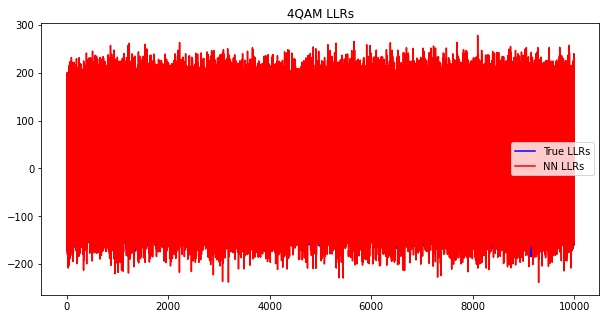

[-131.0438   186.24525  213.22691 ...  170.12225  191.04536  176.59114]


In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
pred_llrs0, pred_llrs1 = model.predict([sym_r[3], sym_i[3]], verbose = 1, batch_size = None)
plt.plot(LLR1[3][0],'b', label = 'True LLRs',zorder=2)
plt.plot(pred_llrs1[0],'r', label = 'NN LLRs')
plt.title('4QAM LLRs')
plt.legend()
plt.show()
fig.savefig("LLRs_4QAM_15.png")
print (pred_llrs0[0])

**Plot LLRs of Bit #0**

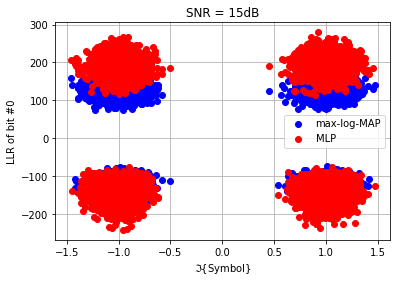

[-131.0438   186.24525  213.22691 ...  170.12225  191.04536  176.59114]


In [0]:
fig2 = plt.figure()
plt.grid(True)
plt.scatter(sym_i[3], LLR0[3], c='b', label = 'max-log-MAP',zorder=2)
plt.scatter(sym_i[3], pred_llrs0[0], c='r', label = 'MLP',zorder=3)
plt.ylabel('LLR of bit #0')
plt.xlabel(r'$\Im$' + '{Symbol}')
plt.title('SNR = 15dB')
plt.legend()
fig2.savefig("Plots/4QAM_LLR_b0_15.png")
plt.show()
print (pred_llrs0[0])

**Plot LLRs of Bit #1**

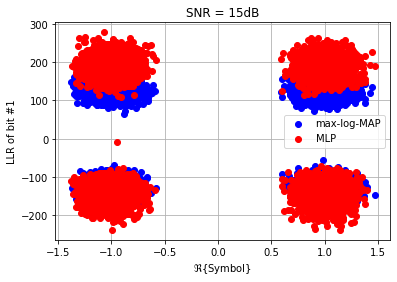

[-143.08578 -167.9631   182.76183 ... -113.93638  180.73138 -155.07198]


In [0]:
fig3 = plt.figure()
plt.grid(True)
plt.scatter(sym_r[3], LLR1[3], c='b', label = 'max-log-MAP',zorder=2)
plt.scatter(sym_r[3], pred_llrs1[0], c='r', label = 'MLP',zorder=3)
plt.ylabel('LLR of bit #1')
plt.xlabel(r'$\Re$' + '{Symbol}')
plt.title('SNR = 15dB')
plt.legend()
fig3.savefig("Plots/4QAM_LLR_b1_15.png")
plt.show()
print(pred_llrs1[0])